In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Rescaling

# from tensorflow.keras.layers import Dropout
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# **Downloading data**

In [ ]:
!pip install kaggle

### uploading kaggle api token

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"deenagautam","key":"f34672e879d3a53eb7e39f94a8064d30"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Ensure the file has the correct permissions

In [ ]:
!kaggle datasets download -d yassershrief/hockey-fight-vidoes

Dataset URL: https://www.kaggle.com/datasets/yassershrief/hockey-fight-vidoes
License(s): unknown
 98% 161M/164M [00:01<00:00, 76.4MB/s]
100% 164M/164M [00:01<00:00, 87.2MB/s]


In [ ]:
!kaggle datasets download -d naveenk903/movies-fight-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/naveenk903/movies-fight-detection-dataset
License(s): unknown
100% 443M/444M [00:07<00:00, 66.4MB/s]
100% 444M/444M [00:07<00:00, 58.8MB/s]


In [ ]:
# !kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

### unziping the data

In [ ]:
!unzip hockey-fight-vidoes.zip

Archive:  hockey-fight-vidoes.zip
  inflating: data/fi100_xvid.avi     
  inflating: data/fi101_xvid.avi     
  inflating: data/fi102_xvid.avi     
  inflating: data/fi103_xvid.avi     
  inflating: data/fi104_xvid.avi     
  inflating: data/fi105_xvid.avi     
  inflating: data/fi106_xvid.avi     
  inflating: data/fi107_xvid.avi     
  inflating: data/fi108_xvid.avi     
  inflating: data/fi109_xvid.avi     
  inflating: data/fi10_xvid.avi      
  inflating: data/fi110_xvid.avi     
  inflating: data/fi111_xvid.avi     
  inflating: data/fi112_xvid.avi     
  inflating: data/fi113_xvid.avi     
  inflating: data/fi114_xvid.avi     
  inflating: data/fi115_xvid.avi     
  inflating: data/fi116_xvid.avi     
  inflating: data/fi117_xvid.avi     
  inflating: data/fi118_xvid.avi     
  inflating: data/fi119_xvid.avi     
  inflating: data/fi11_xvid.avi      
  inflating: data/fi120_xvid.avi     
  inflating: data/fi121_xvid.avi     
  inflating: data/fi122_xvid.avi     
  inflating: dat

In [ ]:
!unzip movies-fight-detection-dataset.zip

Archive:  movies-fight-detection-dataset.zip
  inflating: Peliculas/fights/newfi1.avi  
  inflating: Peliculas/fights/newfi10.avi  
  inflating: Peliculas/fights/newfi100.avi  
  inflating: Peliculas/fights/newfi11.avi  
  inflating: Peliculas/fights/newfi12.avi  
  inflating: Peliculas/fights/newfi13.avi  
  inflating: Peliculas/fights/newfi14.avi  
  inflating: Peliculas/fights/newfi15.avi  
  inflating: Peliculas/fights/newfi16.avi  
  inflating: Peliculas/fights/newfi17.avi  
  inflating: Peliculas/fights/newfi18.avi  
  inflating: Peliculas/fights/newfi19.avi  
  inflating: Peliculas/fights/newfi2.avi  
  inflating: Peliculas/fights/newfi20.avi  
  inflating: Peliculas/fights/newfi21.avi  
  inflating: Peliculas/fights/newfi22.avi  
  inflating: Peliculas/fights/newfi23.avi  
  inflating: Peliculas/fights/newfi24.avi  
  inflating: Peliculas/fights/newfi25.avi  
  inflating: Peliculas/fights/newfi26.avi  
  inflating: Peliculas/fights/newfi27.avi  
  inflating: Peliculas/fights/ne

# **Preprocessing**

In [ ]:
# Function to extract frames from video
def extract_frames(video_path, target_height, target_width, num_frames):
    frames = []
   # creating an object which allows access to the video frames
    cap = cv2.VideoCapture(video_path)
    # getting frame count for a video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # creating a list of length = num of frames
    frame_indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    # iterating over each index in frame_indices
    for idx in frame_indices:
        # setting the frame position to the current index
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        # reading the frame at the current position
        ret, frame = cap.read()
        if ret:
            # resizing each frame to 160 x 160
            frame = cv2.resize(frame, (target_width, target_height))
            # converting each frame to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frames.append(frame)

    cap.release()
    return frames

# Function to preprocess video data
def preprocess_hockey_data(data_dir, target_height, target_width, num_frames):
    X = []
    y = []
    c=0
    for video_name in os.listdir(data_dir):
        c=c+1
        if video_name.startswith('fi'):  # Violence video : fi = fight
            label = 1
        elif video_name.startswith('no'):  # Non-violence video : no = no fight
            label = 0
        else:
            continue

        video_path = os.path.join(data_dir, video_name)
        # fetching preprocessed frames
        frames = extract_frames(video_path, target_height, target_width, num_frames)
        if len(frames) == num_frames:
            X.append(frames)
            y.append(label)
            print(c)

    X = np.array(X)
    y = np.array(y)
    return X, y

def preprocess_movies_data(data_dir, target_height, target_width, num_frames):
    X = []
    y = []
    c=0

    for result in os.listdir(data_dir):
        if result.startswith('fight'):
            label = 1  # Fight
        elif result.startswith('no'):
            label = 0  # No Fight
        else:
          continue
        result_path=os.path.join(data_dir,result)
        print(result)

        for video_name in os.listdir(result_path):
            c=c+1
            video_path = os.path.join(result_path, video_name)
            print(video_path)
            # fetching preprocessed frames
            frames = extract_frames(video_path, target_height, target_width, num_frames)
            if len(frames) == num_frames:
                X.append(frames)
                y.append(label)
                print(c)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
# os.listdir(data_dir_real_life)

['NonViolence', 'Violence']

In [ ]:
# directory paths
data_dir_hockey = '/content/data'
data_dir_movies = '/content/Peliculas'

In [ ]:
# Parameters
target_height = 160
target_width = 160
num_frames = 16
batch_size = 32
epochs = 15

In [ ]:
# Preprocess hockey data
X_h, y_h = preprocess_hockey_data(data_dir_hockey, target_height, target_width, num_frames)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
# Preprocess movies data
X_m, y_m = preprocess_movies_data(data_dir_movies, target_height, target_width, num_frames)

noFights
/content/Peliculas/noFights/28.mpg
1
/content/Peliculas/noFights/94.mpg
2
/content/Peliculas/noFights/59.mpg
3
/content/Peliculas/noFights/74.mpg
4
/content/Peliculas/noFights/78.mpg
5
/content/Peliculas/noFights/43 (1).mpg
6
/content/Peliculas/noFights/19.mpg
7
/content/Peliculas/noFights/98.mpg
8
/content/Peliculas/noFights/12 (1).mpg
9
/content/Peliculas/noFights/23.mpg
10
/content/Peliculas/noFights/79.mpg
11
/content/Peliculas/noFights/91.mpg
12
/content/Peliculas/noFights/9.mpg
13
/content/Peliculas/noFights/85.mpg
14
/content/Peliculas/noFights/75.mpg
15
/content/Peliculas/noFights/17.mpg
16
/content/Peliculas/noFights/73.mpg
17
/content/Peliculas/noFights/57.mpg
18
/content/Peliculas/noFights/29.mpg
19
/content/Peliculas/noFights/66.mpg
20
/content/Peliculas/noFights/89.mpg
21
/content/Peliculas/noFights/87.mpg
22
/content/Peliculas/noFights/90.mpg
23
/content/Peliculas/noFights/51.mpg
24
/content/Peliculas/noFights/58.mpg
25
/content/Peliculas/noFights/55.mpg
26
/cont

# **Shuffling and Splitting**

In [ ]:
X=np.concatenate((X_h,X_m),axis=0)
y=np.concatenate((y_h,y_m),axis=0)

In [ ]:
X.shape

(1201, 16, 160, 160, 3)

- 1201 videos
- 16 frames from each video
- 160 height and width
- 3 channels RGB

In [ ]:
y.shape

(1201,)

In [ ]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

In [ ]:
x_shuffled = X[indices]
y_shuffled = y[indices]

In [ ]:
x_shuffled.shape

(1201, 16, 160, 160, 3)

In [ ]:
y_shuffled.shape

(1201,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_shuffled, y_shuffled, test_size=0.2, random_state=42, stratify=y_shuffled)

In [ ]:
print(f"X_train -> {X_train.shape}")
print(f"y_train -> {y_train.shape}")
print(f"X_test -> {X_test.shape}")
print(f"y_test -> {y_test.shape}")


X_train -> (960, 16, 160, 160, 3)
y_train -> (960,)
X_test -> (241, 16, 160, 160, 3)
y_test -> (241,)


# **Creating model**

In [ ]:
def VD_model(tf):

    layers = tf.keras.layers
    models = tf.keras.models
    num_classes = 2

    # Load the VGG19 model
    base_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(160, 160, 3))

    # Freeze all layers initially
    base_model.trainable = False


    # CNN for feature extraction
    cnn = models.Sequential()
    cnn.add(layers.Rescaling(1./255, input_shape=(160, 160, 3)))
    cnn.add(base_model)
    cnn.add(layers.Flatten())

    # Final sequential model for video classification
    model = models.Sequential()
    model.add(layers.TimeDistributed(cnn, input_shape=(num_frames, target_height, target_width, 3)))
    model.add(layers.LSTM(30, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(90)))
    model.add(layers.Dropout(0.1))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    # if wghts:
    #     model.load_weights(wghts)

    # compiler
    adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])

    return model

In [ ]:
# input_shape = (num_frames, target_height, target_width, 3)
model = VD_model(tf)
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 16, 12800)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16, 30)              │       1,539,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 90)              │           2,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 90)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 90)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          46,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,613,999 (82.45 MB)

 Trainable params: 1,589,615 (6.06 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# **Training**

In [ ]:
# Callbacks
callbacks = [
    # reducing learning rate by the factor of 0.2 if the validation loss doesnt improve for atleast 3 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
    # the model will be saved when validation accuracy improves
    ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    # stop training if validation loss doesnt improve for 5 epochs
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

In [ ]:

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_split=0.2,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7067 - loss: 0.5516
Epoch 1: val_accuracy improved from -inf to 0.86979, saving model to best_model_weights.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7114 - loss: 0.5460 - val_accuracy: 0.8698 - val_loss: 0.2911 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9047 - loss: 0.2516
Epoch 2: val_accuracy improved from 0.86979 to 0.90625, saving model to best_model_weights.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9055 - loss: 0.2501 - val_accuracy: 0.9062 - val_loss: 0.2772 - learning_rate: 0.0010
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9589 - loss: 0.1195
Epoch 3: val_accuracy improved from 0.90625 to 0.91146, saving model to best_model_weights.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9585 - loss: 0.1208 - val_accuracy: 0.9115 - val_loss: 0.2958 - learning_rate: 0.0010
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/st

## **saving weights**

In [ ]:

# Saving the trained model weights
model.save_weights('final_model_scaled1.weights.h5')
# save the model
model.save('violence_detection_model_scaled1.keras')

# **Performance**

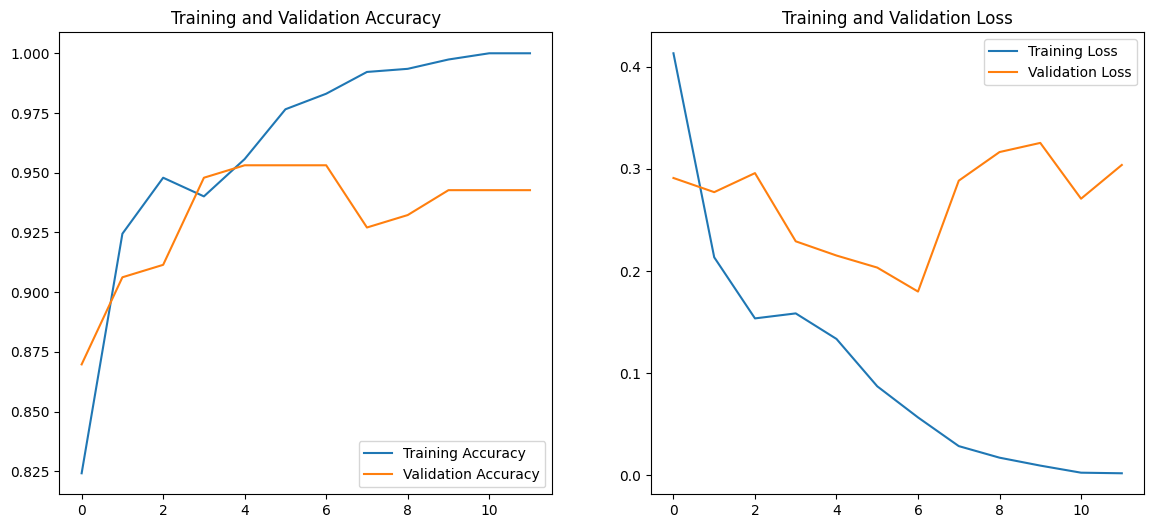

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# y_test_encoded = encoder.transform(y_test.reshape(-1,1))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9586 - loss: 0.1283
Test Accuracy: 96.68%


In [ ]:
y_pred = model.predict(X_test)


8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


In [ ]:
y_pred_binary = np.where(y_pred > 0.52, 1, 0)

In [ ]:
accuracy_score(y_test, y_pred_binary)

0.966804979253112

In [ ]:
f1_score(y_test, y_pred_binary)

0.9666666666666667

In [ ]:
# import sklearn
confusion_matrix(y_test, y_pred_binary)

array([[117,   4],
       [  4, 116]])

In [ ]:
l=[]
for i in np.arange(0.5,0.76,0.01):
  y_pred_binary = np.where(y_pred > i, 1, 0)
  a = accuracy_score(y_test, y_pred_binary)
  l.append(a)
  print(i,a)

0.5 0.966804979253112
0.51 0.966804979253112
0.52 0.966804979253112
0.53 0.966804979253112
0.54 0.966804979253112
0.55 0.966804979253112
0.56 0.9626556016597511
0.5700000000000001 0.9626556016597511
0.5800000000000001 0.9585062240663901
0.5900000000000001 0.9585062240663901
0.6000000000000001 0.9585062240663901
0.6100000000000001 0.9585062240663901
0.6200000000000001 0.9585062240663901
0.6300000000000001 0.9585062240663901
0.6400000000000001 0.9543568464730291
0.6500000000000001 0.9543568464730291
0.6600000000000001 0.9543568464730291
0.6700000000000002 0.9543568464730291
0.6800000000000002 0.9543568464730291
0.6900000000000002 0.9543568464730291
0.7000000000000002 0.950207468879668
0.7100000000000002 0.946058091286307
0.7200000000000002 0.946058091286307
0.7300000000000002 0.946058091286307
0.7400000000000002 0.946058091286307
0.7500000000000002 0.9377593360995851


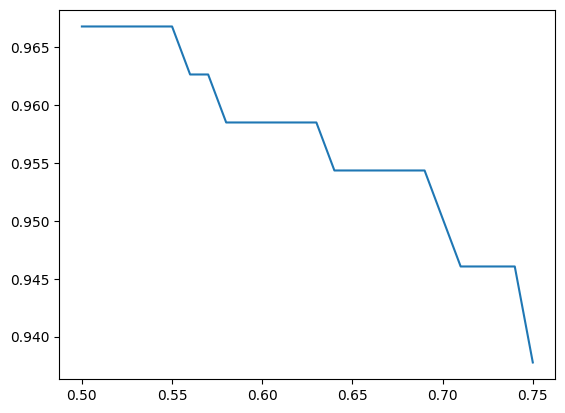

In [ ]:
plt.plot(np.arange(0.5,0.76,0.01),l)

In [ ]:
y_pred

array([[0.10222939],
       [0.9972184 ],
       [0.00741453],
       [0.8899163 ],
       [0.9985545 ],
       [0.00237195],
       [0.00319133],
       [0.9817616 ],
       [0.00668056],
       [0.29428187],
       [0.99052167],
       [0.00662393],
       [0.0029054 ],
       [0.00742811],
       [0.00345763],
       [0.9892021 ],
       [0.9883151 ],
       [0.99130917],
       [0.01438421],
       [0.9648687 ],
       [0.04417212],
       [0.00570557],
       [0.99861217],
       [0.00396144],
       [0.00397121],
       [0.9855965 ],
       [0.0037236 ],
       [0.00450358],
       [0.00294002],
       [0.00356238],
       [0.8204547 ],
       [0.00235315],
       [0.00381952],
       [0.00342596],
       [0.00723421],
       [0.984162  ],
       [0.01762295],
       [0.00708581],
       [0.9951729 ],
       [0.9978517 ],
       [0.9498556 ],
       [0.01087554],
       [0.7436869 ],
       [0.99254954],
       [0.9403455 ],
       [0.99784756],
       [0.02820831],
       [0.934

In [ ]:
y_pred_binary

array([[0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
    

<Axes: >

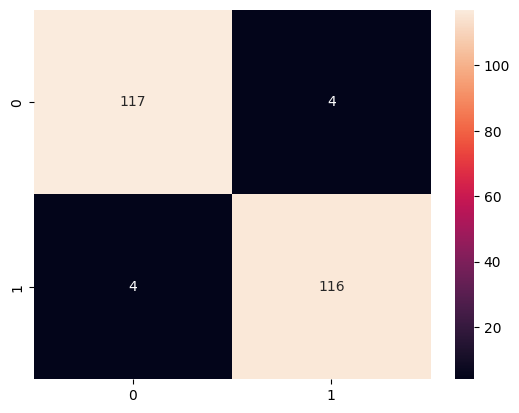

In [ ]:
# y_pred_binary = np.where(y_pred > 0.9, 1, 0)
sns.heatmap(confusion_matrix(y_test, y_pred_binary), annot=True, fmt='d')